In [1]:
import argparse
import sys
import os
import json
import torch
import os
import random
import utils
import data_utils
from IPython.display import display, HTML, Video

import json
from debugging import visualize_gif
import cbm
import plots
def parse_args():
    parser = argparse.ArgumentParser(description='Settings for creating CBM')
    # parser.add_argument('--batch_size', default=64, type=int)
    # parser.add_argument('--epochs', default=30, type=int)
    parser.add_argument('--update_freq', default=1, type=int)
    parser.add_argument('--save_ckpt_freq', default=100, type=int)

    # Model parameters
    parser.add_argument('--model', default='vit_base_patch16_224', type=str, metavar='MODEL',
                        help='Name of model to train')
    parser.add_argument('--tubelet_size', type=int, default= 2)
    parser.add_argument('--input_size', default=224, type=int,
                        help='videos input size')

    parser.add_argument('--fc_drop_rate', type=float, default=0.0, metavar='PCT',
                        help='Dropout rate (default: 0.)')
    parser.add_argument('--drop', type=float, default=0.0, metavar='PCT',
                        help='Dropout rate (default: 0.)')
    parser.add_argument('--attn_drop_rate', type=float, default=0.0, metavar='PCT',
                        help='Attention dropout rate (default: 0.)')
    parser.add_argument('--drop_path', type=float, default=0.1, metavar='PCT',
                        help='Drop path rate (default: 0.1)')

    parser.add_argument('--disable_eval_during_finetuning', action='store_true', default=False)
    parser.add_argument('--model_ema', action='store_true', default=False)
    parser.add_argument('--model_ema_decay', type=float, default=0.9999, help='')
    parser.add_argument('--model_ema_force_cpu', action='store_true', default=False, help='')

    # Optimizer parameters
    parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                        help='Optimizer (default: "adamw"')
    parser.add_argument('--opt_eps', default=1e-8, type=float, metavar='EPSILON',
                        help='Optimizer Epsilon (default: 1e-8)')
    parser.add_argument('--opt_betas', default=None, type=float, nargs='+', metavar='BETA',
                        help='Optimizer Betas (default: None, use opt default)')
    parser.add_argument('--clip_grad', type=float, default=None, metavar='NORM',
                        help='Clip gradient norm (default: None, no clipping)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')
    parser.add_argument('--weight_decay_end', type=float, default=None, help="""Final value of the
        weight decay. We use a cosine schedule for WD and using a larger decay by
        the end of training improves performance for ViTs.""")

    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-3)')
    parser.add_argument('--layer_decay', type=float, default=0.75)

    parser.add_argument('--warmup_lr', type=float, default=1e-6, metavar='LR',
                        help='warmup learning rate (default: 1e-6)')
    parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0 (1e-5)')

    parser.add_argument('--warmup_epochs', type=int, default=5, metavar='N',
                        help='epochs to warmup LR, if scheduler supports')
    parser.add_argument('--warmup_steps', type=int, default=-1, metavar='N',
                        help='num of steps to warmup LR, will overload warmup_epochs if set > 0')

    # Augmentation parameters
    parser.add_argument('--color_jitter', type=float, default=0.4, metavar='PCT',
                        help='Color jitter factor (default: 0.4)')
    parser.add_argument('--num_sample', type=int, default=1,
                        help='Repeated_aug (default: 2)')
    parser.add_argument('--aa', type=str, default='rand-m7-n4-mstd0.5-inc1', metavar='NAME',
                        help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m7-n4-mstd0.5-inc1)'),
    parser.add_argument('--smoothing', type=float, default=0.1,
                        help='Label smoothing (default: 0.1)')
    parser.add_argument('--train_interpolation', type=str, default='bicubic',
                        help='Training interpolation (random, bilinear, bicubic default: "bicubic")')

    # Evaluation parameters
    parser.add_argument('--crop_pct', type=float, default=None)
    parser.add_argument('--short_side_size', type=int, default=224)
    parser.add_argument('--test_num_segment', type=int, default=5)
    parser.add_argument('--test_num_crop', type=int, default=3)

    # Random Erase params
    parser.add_argument('--reprob', type=float, default=0.25, metavar='PCT',
                        help='Random erase prob (default: 0.25)')
    parser.add_argument('--remode', type=str, default='pixel',
                        help='Random erase mode (default: "pixel")')
    parser.add_argument('--recount', type=int, default=1,
                        help='Random erase count (default: 1)')
    parser.add_argument('--resplit', action='store_true', default=False,
                        help='Do not random erase first (clean) augmentation split')

    # Mixup params
    parser.add_argument('--mixup', type=float, default=0.0,
                        help='mixup alpha, mixup enabled if > 0.')
    parser.add_argument('--cutmix', type=float, default=0.0,
                        help='cutmix alpha, cutmix enabled if > 0.')
    parser.add_argument('--cutmix_minmax', type=float, nargs='+', default=None,
                        help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
    parser.add_argument('--mixup_prob', type=float, default=0.0,
                        help='Probability of performing mixup or cutmix when either/both is enabled')
    parser.add_argument('--mixup_switch_prob', type=float, default=0.0,
                        help='Probability of switching to cutmix when both mixup and cutmix enabled')
    parser.add_argument('--mixup_mode', type=str, default='batch',
                        help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')

    # Finetuning params
    parser.add_argument('--finetune', default='', help='finetune from checkpoint')
    parser.add_argument('--model_key', default='model|module', type=str)
    parser.add_argument('--model_prefix', default='', type=str)
    parser.add_argument('--init_scale', default=0.001, type=float)
    parser.add_argument('--use_checkpoint', action='store_true')
    parser.set_defaults(use_checkpoint=False)
    parser.add_argument('--use_mean_pooling', action='store_true')
    parser.set_defaults(use_mean_pooling=True)
    parser.add_argument('--use_cls', action='store_false', dest='use_mean_pooling')

    # Dataset parameters

    parser.add_argument('--eval_data_path', default=None, type=str,
                        help='dataset path for evaluation')
    parser.add_argument('--nb_classes', default=400, type=int,
                        help='number of the classification types')
    parser.add_argument('--imagenet_default_mean_and_std', default=True, action='store_true')
    parser.add_argument('--num_segments', type=int, default= 1)
    parser.add_argument('--num_frames', type=int, default= 16)
    parser.add_argument('--sampling_rate', type=int, default= 4)
    parser.add_argument('--data_set', default='Kinetics-400', choices=['kinetics100','kinetics400', 'mini-SSV2','SSV2', 'UCF101', 'HMDB51','image_folder'],
                        type=str, help='dataset')
    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--log_dir', default=None,
                        help='path where to tensorboard log')
    # parser.add_argument('--device', default='cuda',
    #                     help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='',
                        help='resume from checkpoint')
    parser.add_argument('--auto_resume', action='store_true')
    parser.add_argument('--no_auto_resume', action='store_false', dest='auto_resume')
    parser.set_defaults(auto_resume=True)

    parser.add_argument('--save_ckpt', action='store_true')
    parser.add_argument('--no_save_ckpt', action='store_false', dest='save_ckpt')
    parser.set_defaults(save_ckpt=True)

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true',
                        help='Perform evaluation only')
    parser.add_argument('--dist_eval', action='store_true', default=False,
                        help='Enabling distributed evaluation')
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--pin_mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')
    parser.set_defaults(pin_mem=True)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local-rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')

    parser.add_argument('--enable_deepspeed', action='store_true', default=False)
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    parser.add_argument("--dataset", type=str, default="cifar10")
    parser.add_argument("--s_concept_set", type=str, default=None, 
                        help="path to concept set name")
    parser.add_argument("--t_concept_set", type=str, default=None, 
                        help="path to concept set name")
    parser.add_argument("--backbone", type=str, default="clip_RN50", help="Which pretrained model to use as backbone")
    parser.add_argument("--clip_name", type=str, default="ViT-B/16", help="Which CLIP model to use")

    parser.add_argument("--device", type=str, default="cuda", help="Which device to use")
    parser.add_argument("--batch_size", type=int, default=512, help="Batch size used when saving model/CLIP activations")
    parser.add_argument("--saga_batch_size", type=int, default=256, help="Batch size used when fitting final layer")
    parser.add_argument("--proj_batch_size", type=int, default=50000, help="Batch size to use when learning projection layer")

    parser.add_argument("--feature_layer", type=str, default='layer4', 
                        help="Which layer to collect activations from. Should be the name of second to last layer in the model")
    parser.add_argument("--activation_dir", type=str, default='saved_activations', help="save location for backbone and CLIP activations")
    parser.add_argument("--save_dir", type=str, default='saved_models', help="where to save trained models")
    parser.add_argument("--clip_cutoff", type=float, default=0.25, help="concepts with smaller top5 clip activation will be deleted")
    parser.add_argument("--proj_steps", type=int, default=1000, help="how many steps to train the projection layer for")
    parser.add_argument("--interpretability_cutoff", type=float, default=0.45, help="concepts with smaller similarity to target concept will be deleted")
    parser.add_argument("--lam", type=float, default=0.0007, help="Sparsity regularization parameter, higher->more sparse")
    parser.add_argument("--n_iters", type=int, default=1000, help="How many iterations to run the final layer solver for")
    parser.add_argument("--print", action='store_true', help="Print all concepts being deleted in this stage")
    parser.add_argument('--data_path', default='data/video_annotation/ucf101', type=str,
                        help='dataset path')
    parser.add_argument('--video_anno_path',type=str)
    parser.add_argument('--center_frame',action='store_true')
    parser.add_argument('--no_aug',type=bool,default=False)
    parser.add_argument('--saved_features',action='store_true')
    parser.add_argument('--dual_encoder', default='clip', choices=['clip', 'lavila', 'internvid'],
                        type=str, help='dataset')
    parser.add_argument('--dual_encoder_frames',type=int,default=16)
    parser.add_argument('--lavila_ckpt',type=str,default=None)
    return parser



import json

def get_selected_args_from_file(args_file, selected_keys):
    # 파일을 읽어서 JSON 파싱
    with open(args_file, 'r') as f:
        args_dict = json.load(f)  # JSON 형식의 파일을 파이썬 딕셔너리로 변환

    # 선택한 key에 해당하는 값만 추출하여 argparse 형식으로 변환
    args_list = []
    for key in selected_keys:
        if key in args_dict:
            args_list.append(f'--{key}')  # key를 --key 형식으로 변환
            args_list.append(str(args_dict[key]))  # 값을 문자열로 변환해서 리스트에 추가

    return args_list

load_dir = "/data/jong980812/project/Video-CBM-two-stream/new_results/three_joint_no_prompt/new_norm/model/kinetics400_cbm_2024_10_23_20_36"
selected_keys = [
        'data_set', 'nb_classes', 'video_anno_path', 'data_path', 'lavila_ckpt', 'finetune', 'backbone'
    ]
args_list = get_selected_args_from_file(os.path.join(load_dir,'args.txt'),selected_keys)  # 파일에서 인자 리스트 생성
parser = parse_args()
argument = parser.parse_args(args_list)  # 파일에서 읽은 인자로 파싱
device = "cuda"
with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["data_set"]
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]
with open(cls_file, "r") as f:
    classes = f.read().split("\n")
val_data_t = data_utils.get_data(val_d_probe,args=argument)
val_data_t.visualize=True
print(val_data_t.center_frame)
argument.no_aug = True
argument.center_frame = True
val_pil_data = data_utils.get_data(val_d_probe,args=argument)
val_pil_data.end_point = 2

/data/jong980812/anaconda3/envs/video-cbm/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/data/jong980812/anaconda3/envs/video-cbm/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


Number of the class = 400
False
Number of the class = 400


In [2]:

from viclip import get_viclip, retrieve_text, _frame_from_video
import clip

model_cfgs = {
'viclip-l-internvid-10m-flt': {
    'size': 'l',
    'pretrained': 'xxx/ViCLIP-L_InternVid-FLT-10M.pth',
},
'viclip-l-internvid-200m': {
    'size': 'l',
    'pretrained': 'xxx/ViCLIP-L_InternVid-200M.pth',
},
'viclip-b-internvid-10m-flt': {
    'size': 'b',
    'pretrained': '/data/datasets/video_checkpoint/ViCLIP-B_InternVid-FLT-10M.pth',
},
'viclip-b-internvid-200m': {
    'size': 'b',
    'pretrained': '/data/datasets/video_checkpoint/ViCLIP-B_InternVid-200M.pth',
},
}
cfg = model_cfgs['viclip-b-internvid-200m']
model_l = get_viclip(cfg['size'], cfg['pretrained'])
assert(type(model_l)==dict and model_l['viclip'] is not None and model_l['tokenizer'] is not None)
internvid, tokenizer = model_l['viclip'], model_l['tokenizer']
internvid = internvid.to('cuda')
internvid = internvid.eval()

name = 'ViT-B/16'
clip_model, clip_preprocess = clip.load(name, device=device)


<All keys matched successfully>


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def visualize_concept_sim(visual_feat,text_feat,p_words):
    # Step 1: Compute cosine similarity between visual_feat and each row in text_features
    similarities = cosine_similarity(visual_feat, text_feat).flatten()
    print(similarities.shape)
    # Step 2: Create a DataFrame with concepts and their respective similarities
    concept_sim_df = pd.DataFrame({
        'Concept': p_words,
        'Similarity': similarities
    })

    # Step 3: Sort by similarity for clearer visualization
    concept_sim_df = concept_sim_df.sort_values(by="Similarity", ascending=False).reset_index(drop=True)

    # Step 4: Plotting the similarities for each concept
    # plt.figure(figsize=(10, 8))
    # plt.barh(concept_sim_df['Concept'][:20], concept_sim_df['Similarity'][:20])  # Plot top 20 for clarity
    # plt.xlabel("Similarity")
    # plt.ylabel("Concepts")
    # plt.title("Top 20 Concept Similarities with Visual Features")
    # plt.gca().invert_yaxis()
    # plt.show()
    plt.figure(figsize=(6, 4))
    bars = plt.barh(concept_sim_df['Concept'][:8], concept_sim_df['Similarity'][:8])  # Plot top 8 for clarity
    plt.xlabel("Similarity")
    plt.ylabel("Concepts")
    plt.title("Top 8 Concept Similarities with Visual Features")
    plt.gca().invert_yaxis()
    plt.yticks(fontsize=18)

    # Annotate top 3 bars with their similarity values
    for i in range(3):
        plt.text(
            concept_sim_df['Similarity'][i] + 0.01,  # Positioning slightly right of the bar
            i,  # Position on the y-axis
            f"{concept_sim_df['Similarity'][i]:.2f}",  # Formatting the value to 2 decimal places
            va='center'
        )

    plt.show()
def visualize_avg_concept_sim(visual_feat,text_feat,p_words):
    # Step 1: Compute cosine similarity between visual_feat and each row in text_features
    similarities=[]
    for i in range(visual_feat.shape[0]):
        vis = visual_feat[i:i+1]
        similaritiy = cosine_similarity(vis, text_feat).flatten()
        similarities.append(similaritiy)
    similarities=np.mean(similarities,axis=0)
    # Step 2: Create a DataFrame with concepts and their respective similarities
    concept_sim_df = pd.DataFrame({
        'Concept': p_words,
        'Similarity': similarities
    })

    # Step 3: Sort by similarity for clearer visualization
    concept_sim_df = concept_sim_df.sort_values(by="Similarity", ascending=False).reset_index(drop=True)

    # Step 4: Plotting the similarities for each concept
    # plt.figure(figsize=(10, 8))
    # plt.barh(concept_sim_df['Concept'][:20], concept_sim_df['Similarity'][:20])  # Plot top 20 for clarity
    # plt.xlabel("Similarity")
    # plt.ylabel("Concepts")
    # plt.title("Top 20 Concept Similarities with Visual Features")
    # plt.gca().invert_yaxis()
    # plt.show()
    plt.figure(figsize=(6, 4))
    bars = plt.barh(concept_sim_df['Concept'][:8], concept_sim_df['Similarity'][:8])  # Plot top 8 for clarity
    plt.xlabel("Similarity")
    plt.ylabel("Concepts")
    plt.title("Top 8 Concept Similarities with Visual Features")
    plt.gca().invert_yaxis()
    plt.yticks(fontsize=18)

    # Annotate top 3 bars with their similarity values
    for i in range(3):
        plt.text(
            concept_sim_df['Similarity'][i] + 0.01,  # Positioning slightly right of the bar
            i,  # Position on the y-axis
            f"{concept_sim_df['Similarity'][i]:.2f}",  # Formatting the value to 2 decimal places
            va='center'
        )

    plt.show()

In [4]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe,args=argument)
val_data_t.visualize=True
print(val_data_t.center_frame)
val_pil_data = data_utils.get_data(val_d_probe,args=argument)
val_pil_data.no_aug = True
val_pil_data.center_frame = True
val_pil_data.end_point = 2

Number of the class = 400
True
Number of the class = 400


In [9]:
p_concept_set='/data/jong980812/project/Video-CBM-two-stream/data/concept_sets/llava_ver2/k400_3frame.txt'
# p_concept_set='/data/jong980812/project/Video-CBM-two-stream/k400_temporal_4sth_concepts.txt'
# p_concept_set='/data/jong980812/project/Video-CBM-two-stream/data/categories_places365_clean.txt'
# with open(s_concept_set, 'r') as f: 
#     s_words = (f.read()).split('\n')
# with open(t_concept_set, 'r') as f: 
#     t_words = (f.read()).split('\n')

with open(p_concept_set, 'r') as f: 
    p_words = (f.read()).split('\n')
text = internvid.text_encoder.tokenize(["{}".format(word) for word in p_words], context_length=32).to(device)
text_features = []
batch_size=16
import math
with torch.no_grad():
    for i in (range(math.ceil(len(text)/batch_size))):
        text_features.append(internvid.text_encoder(text[batch_size*i:batch_size*(i+1)]))
text_features = torch.cat(text_features, dim=0)
torch.cuda.empty_cache()

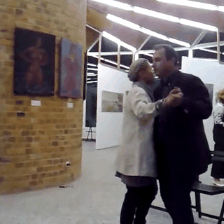

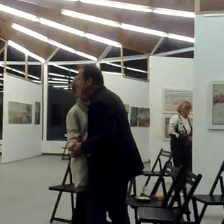

playing saxophone
(859,)


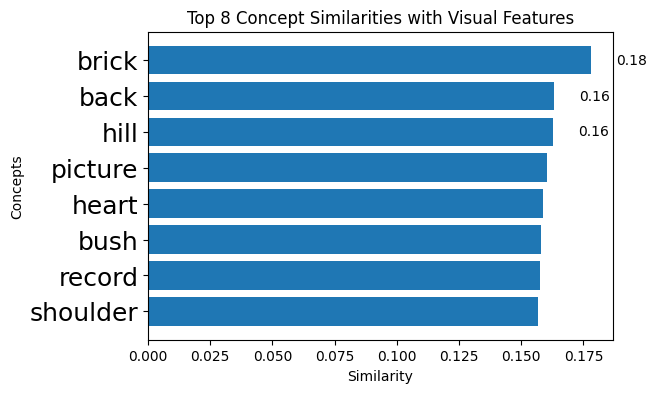

(859,)


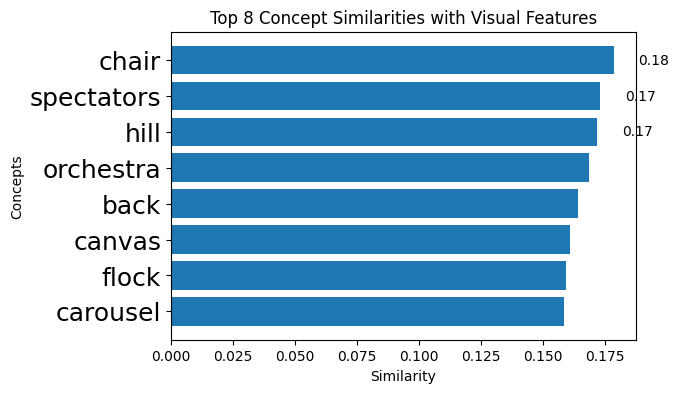

In [14]:
video_index=4
visual_index=2
boring_index =-1
val_pil_data.end_point = visual_index
image,label ,path= val_pil_data[video_index]
x, _ ,_= val_data_t[video_index]
x = x.unsqueeze(0).to(device)
x=x[:,visual_index]
T = x.size(2)
middle_frame = x[:, :, boring_index, :, :]  # Shape (B, C, H, W)
# T배로 복제 (unsqueeze로 차원을 추가한 후 repeat 사용)
boring_video = middle_frame.unsqueeze(2).repeat(1, 1, T, 1, 1)  # Shape (B, C, T, H, W)
visualize_gif(image,label ,path,visual_index,video_index,False)
visualize_gif(image[:,boring_index,:,:].unsqueeze(1).repeat(1, T, 1, 1),label ,path,visual_index,video_index,False)
print(classes[label])
visual_feat = (internvid.encode_vision(x.to(device)))
boring_visual_feat = (internvid.encode_vision(boring_video.to(device)))
visual_feat = visual_feat.cpu().detach()
boring_visual_feat =boring_visual_feat.cpu().detach()
text_feat=text_features.cpu().detach()
visualize_concept_sim(visual_feat,text_feat,p_words)
visualize_concept_sim(boring_visual_feat,text_feat,p_words)

In [ ]:
video_index=3079
visual_index=1
boring_index =-1
val_pil_data.end_point = visual_index
image,label ,path= val_pil_data[video_index]
x, _ ,_= val_data_t[video_index]
x = x.unsqueeze(0).to(device)
x=x[:,visual_index]
T = x.size(2)
middle_frame = x[:, :, boring_index, :, :]  # Shape (B, C, H, W)
# T배로 복제 (unsqueeze로 차원을 추가한 후 repeat 사용)
boring_video = middle_frame.unsqueeze(2).repeat(1, 1, T, 1, 1)  # Shape (B, C, T, H, W)
visualize_gif(image,label ,path,visual_index,video_index,False)
visualize_gif(image[:,boring_index,:,:].unsqueeze(1).repeat(1, T, 1, 1),label ,path,visual_index,video_index,False)
print(classes[label])
visual_feat = (clip.encode_vision(x.to(device)))
boring_visual_feat = (clip.encode_vision(boring_video.to(device)))
visual_feat = visual_feat.cpu().detach()
boring_visual_feat =boring_visual_feat.cpu().detach()
text_feat=text_features.cpu().detach()
visualize_concept_sim(visual_feat,text_feat,p_words)
visualize_concept_sim(boring_visual_feat,text_feat,p_words)

In [16]:
p_concept_set='/data/jong980812/project/Video-CBM-two-stream/data/concept_sets/llava_ver2/k400_3frame.txt'
# p_concept_set='/data/jong980812/project/Video-CBM-two-stream/k400_temporal_4sth_concepts.txt'
# p_concept_set='/data/jong980812/project/Video-CBM-two-stream/data/categories_places365_clean.txt'
# with open(s_concept_set, 'r') as f: 
#     s_words = (f.read()).split('\n')
# with open(t_concept_set, 'r') as f: 
#     t_words = (f.read()).split('\n')

with open(p_concept_set, 'r') as f: 
    p_words = (f.read()).split('\n')
text = clip.tokenize(["a photo of {}.".format(word) for word in p_words]).to(device)
text_features = []
batch_size=16
import math
with torch.no_grad():
    for i in (range(math.ceil(len(text)/batch_size))):
        text_features.append(clip_model.encode_text(text[batch_size*i:batch_size*(i+1)]))
text_features = torch.cat(text_features, dim=0)
torch.cuda.empty_cache()

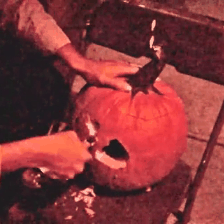

carving pumpkin


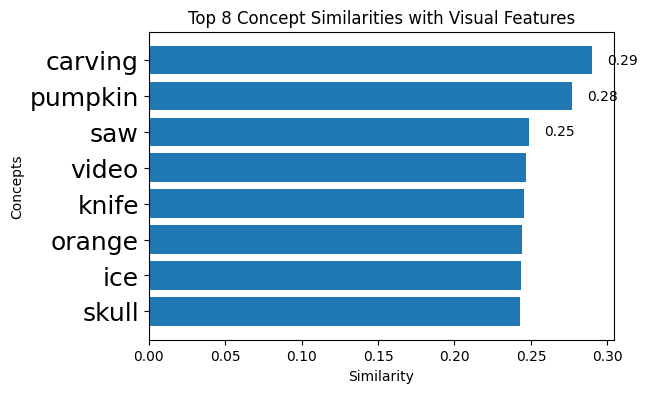

In [17]:
video_index=10
visual_index=2
val_pil_data.end_point = visual_index
image,label ,path= val_pil_data[video_index]
x, _ ,_= val_data_t[video_index]
x = x.unsqueeze(0).to(device)
x=x[:,visual_index]
T = x.size(2)
# T배로 복제 (unsqueeze로 차원을 추가한 후 repeat 사용)
visualize_gif(image,label ,path,visual_index,video_index,False)
visual_feat=[]
print(classes[label])
for i in range(x.shape[2]):
    new_x = x[:,:,i,:,:]
    feat = (clip_model.encode_image(new_x.to(device)))
    visual_feat.append(feat)
visual_feat = torch.cat(visual_feat,dim=0)
visual_feat = visual_feat.cpu().detach()

text_feat=text_features.cpu().detach()
visualize_avg_concept_sim(visual_feat,text_feat,p_words)


In [28]:
visual_feat[].shape

torch.Size([16, 512])

In [24]:
visual_feat[0].shape

torch.Size([1, 512])